## Prediction of cryptocurrency returns using machine learning



*   Barış Özakar
*   Doğan Parlak

> Finance and Machine Learning Course Project




## Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, GRU
import pickle
import gc
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Loading

### Loading data from drive


In [ ]:
!unzip gdrive/My\ Drive/ada.csv.zip
!unzip gdrive/My\ Drive/btc.csv.zip
!unzip gdrive/My\ Drive/doge.csv.zip
!unzip gdrive/My\ Drive/eth.csv.zip
!unzip gdrive/My\ Drive/ltc.csv.zip

Archive:  gdrive/My Drive/ada.csv.zip
  inflating: ada.csv                 
  inflating: __MACOSX/._ada.csv      
Archive:  gdrive/My Drive/btc.csv.zip
  inflating: btc.csv                 
  inflating: __MACOSX/._btc.csv      
Archive:  gdrive/My Drive/doge.csv.zip
  inflating: doge.csv                
  inflating: __MACOSX/._doge.csv     
Archive:  gdrive/My Drive/eth.csv.zip
  inflating: eth.csv                 
  inflating: __MACOSX/._eth.csv      
Archive:  gdrive/My Drive/ltc.csv.zip
  inflating: ltc.csv                 
  inflating: __MACOSX/._ltc.csv      


### Paths of data from Colab Folder

In [ ]:
#Paths of the data
data_ada_path = "/content/ada.csv"
data_btc_path = "/content/btc.csv"
data_doge_path = "/content/doge.csv"
data_eth_path = "/content/eth.csv"
data_ltc_path = "/content/ltc.csv"


### Read data to pandas dataframes

In [ ]:
#Reading the data
data_ada = pd.read_csv(data_ada_path) #720600
data_btc = pd.read_csv(data_btc_path) #720600
data_doge = pd.read_csv(data_doge_path) #720600
data_eth = pd.read_csv(data_eth_path) #720600
data_ltc = pd.read_csv(data_ltc_path) #720600

 Example raw data

In [ ]:
data_btc.head(5)

,time,id,amount,open,high,low,close,count,vol
0,2020-01-01 00:00:00,1577808000,102.743804,7194.70,7200.00,7186.19,7200.00,497,738706.346176
1,2020-01-01 00:01:00,1577808060,70.711661,7200.00,7219.58,7199.99,7218.20,448,509693.211491
2,2020-01-01 00:02:00,1577808120,17.445960,7218.21,7218.44,7213.09,7216.22,248,125889.775364
3,2020-01-01 00:03:00,1577808180,13.034606,7216.21,7221.91,7215.48,7218.37,300,94091.100831
4,2020-01-01 00:04:00,1577808240,14.004800,7218.37,7220.13,7210.01,7213.05,279,101042.531802


### Check for missing values

In [ ]:
#Check missing values
print(data_ada.isnull().values.any())
print(data_btc.isnull().values.any())
print(data_doge.isnull().values.any())
print(data_eth.isnull().values.any())
print(data_ltc.isnull().values.any())

False
False
False
False
False


### Fix up the names of the columns

In [ ]:
#Fix the problem of column names containing empty string in the beginning
data_ada.columns = data_ada.columns.str.replace(' ','')
data_btc.columns = data_btc.columns.str.replace(' ','')
data_doge.columns = data_doge.columns.str.replace(' ','')
data_eth.columns = data_eth.columns.str.replace(' ','')
data_ltc.columns = data_ltc.columns.str.replace(' ','')

## Feature Engineering and Labeling

### Calculation of RSI value

In [ ]:
def RSI(df, n=14):
    delta = df['close'].diff()

    gainers= delta[delta > 0]
    losers= delta[delta < 0]

    ave_gain=gainers.rolling(n).mean()
    ave_loss=losers.rolling(n).mean().abs()


    ave_gain = ave_gain.reindex_like(delta, method='ffill')
    ave_loss = ave_loss.reindex_like(delta, method='ffill')
    RS = ave_gain / ave_loss
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

### Calculation of bollinger bands

In [ ]:
def get_bollinger_bands(df):
    sma_20 = df["20-SMA"]
    std = sma_20.std()
    bollinger_up = sma_20 + std * 2 # Calculate top band
    bollinger_down = sma_20 - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

### Create labels based on minute returns from closing prices

In [ ]:
def create_labels(df):
  delta = df['close'].diff(periods=-1)
  y=pd.DataFrame((delta < 0).astype(int))
  y=y.rename(columns={"close": "y"})
  return y

### Introducing features including EMAs and SMAs as new columns to the dataframe

In [ ]:
def create_features(df, shifts=[1,2,3,4,5]):
    X = pd.DataFrame(index=df.index)
    for m in shifts:
      X["return"+"-"+str(m)] = df["close"].pct_change(periods=m)  #adds m-min return
    for column in df.columns[2:]:
      X[column]=df[column]
    X["range"]=df["high"]-df["low"]
    X["7-SMA"]=X["close"].rolling(window=7).mean()
    X["14-SMA"]=X["close"].rolling(window=14).mean()
    X["20-SMA"]=X["close"].rolling(window=20).mean()
    bol_up, bol_down=get_bollinger_bands(X)
    X["DistanceFromBollingerUp"] = bol_up - X["close"]
    X["DistanceFromBollingerDown"] = X["close"] - bol_down
    X["7-EMA"]=X["close"].ewm(span=7, min_periods=7).mean()
    X["14-EMA"]=X["close"].ewm(span=14, min_periods=14).mean()
    X["MACD"]=X["close"].ewm(span=12, min_periods=12).mean()-X["close"].ewm(span=26, min_periods=26).mean()
    X["RSI"]=RSI(df, 14)
    return X.dropna()

Example view of final version of the data

In [ ]:
ada_X = create_features(data_ada)
btc_X = create_features(data_btc)
doge_X = create_features(data_doge)
eth_X = create_features(data_eth)
ltc_X = create_features(data_ltc)
btc_X.head(3)

,return-1,return-2,return-3,return-4,return-5,amount,open,high,low,close,count,vol,range,7-SMA,14-SMA,20-SMA,DistanceFromBollingerUp,DistanceFromBollingerDown,7-EMA,14-EMA,MACD,RSI
28,0.000809,0.000183,0.000482,0.000486,0.000039,19.491650,7216.43,7221.32,7216.36,7221.32,61,140662.048511,4.96,7218.654286,7216.091429,7214.294,35709.025083,35723.077083,7218.471305,7216.962021,1.673359,57.999400
29,0.000219,0.001028,0.000402,0.000701,0.000705,5.670964,7220.44,7222.90,7218.18,7222.90,91,40944.090834,4.72,7219.484286,7216.912857,7214.618,35707.769083,35724.333083,7219.578676,7217.764719,1.939848,52.014746
30,0.000233,0.000451,0.001261,0.000634,0.000934,19.967501,7222.91,7225.71,7221.75,7224.58,128,144235.501834,3.96,7219.990000,7218.226429,7215.450,35706.921083,35725.181083,7220.829175,7218.684313,2.248379,51.820608


Example view of final version of the labels

In [ ]:
ada_y = create_labels(ada_X)
btc_y = create_labels(btc_X)
doge_y = create_labels(doge_X)
eth_y = create_labels(eth_X)
ltc_y = create_labels(ltc_X)
btc_y.head(5)

,y
28,1
29,1
30,1
31,0
32,1


## Feature Selection

### Value Density Visualization

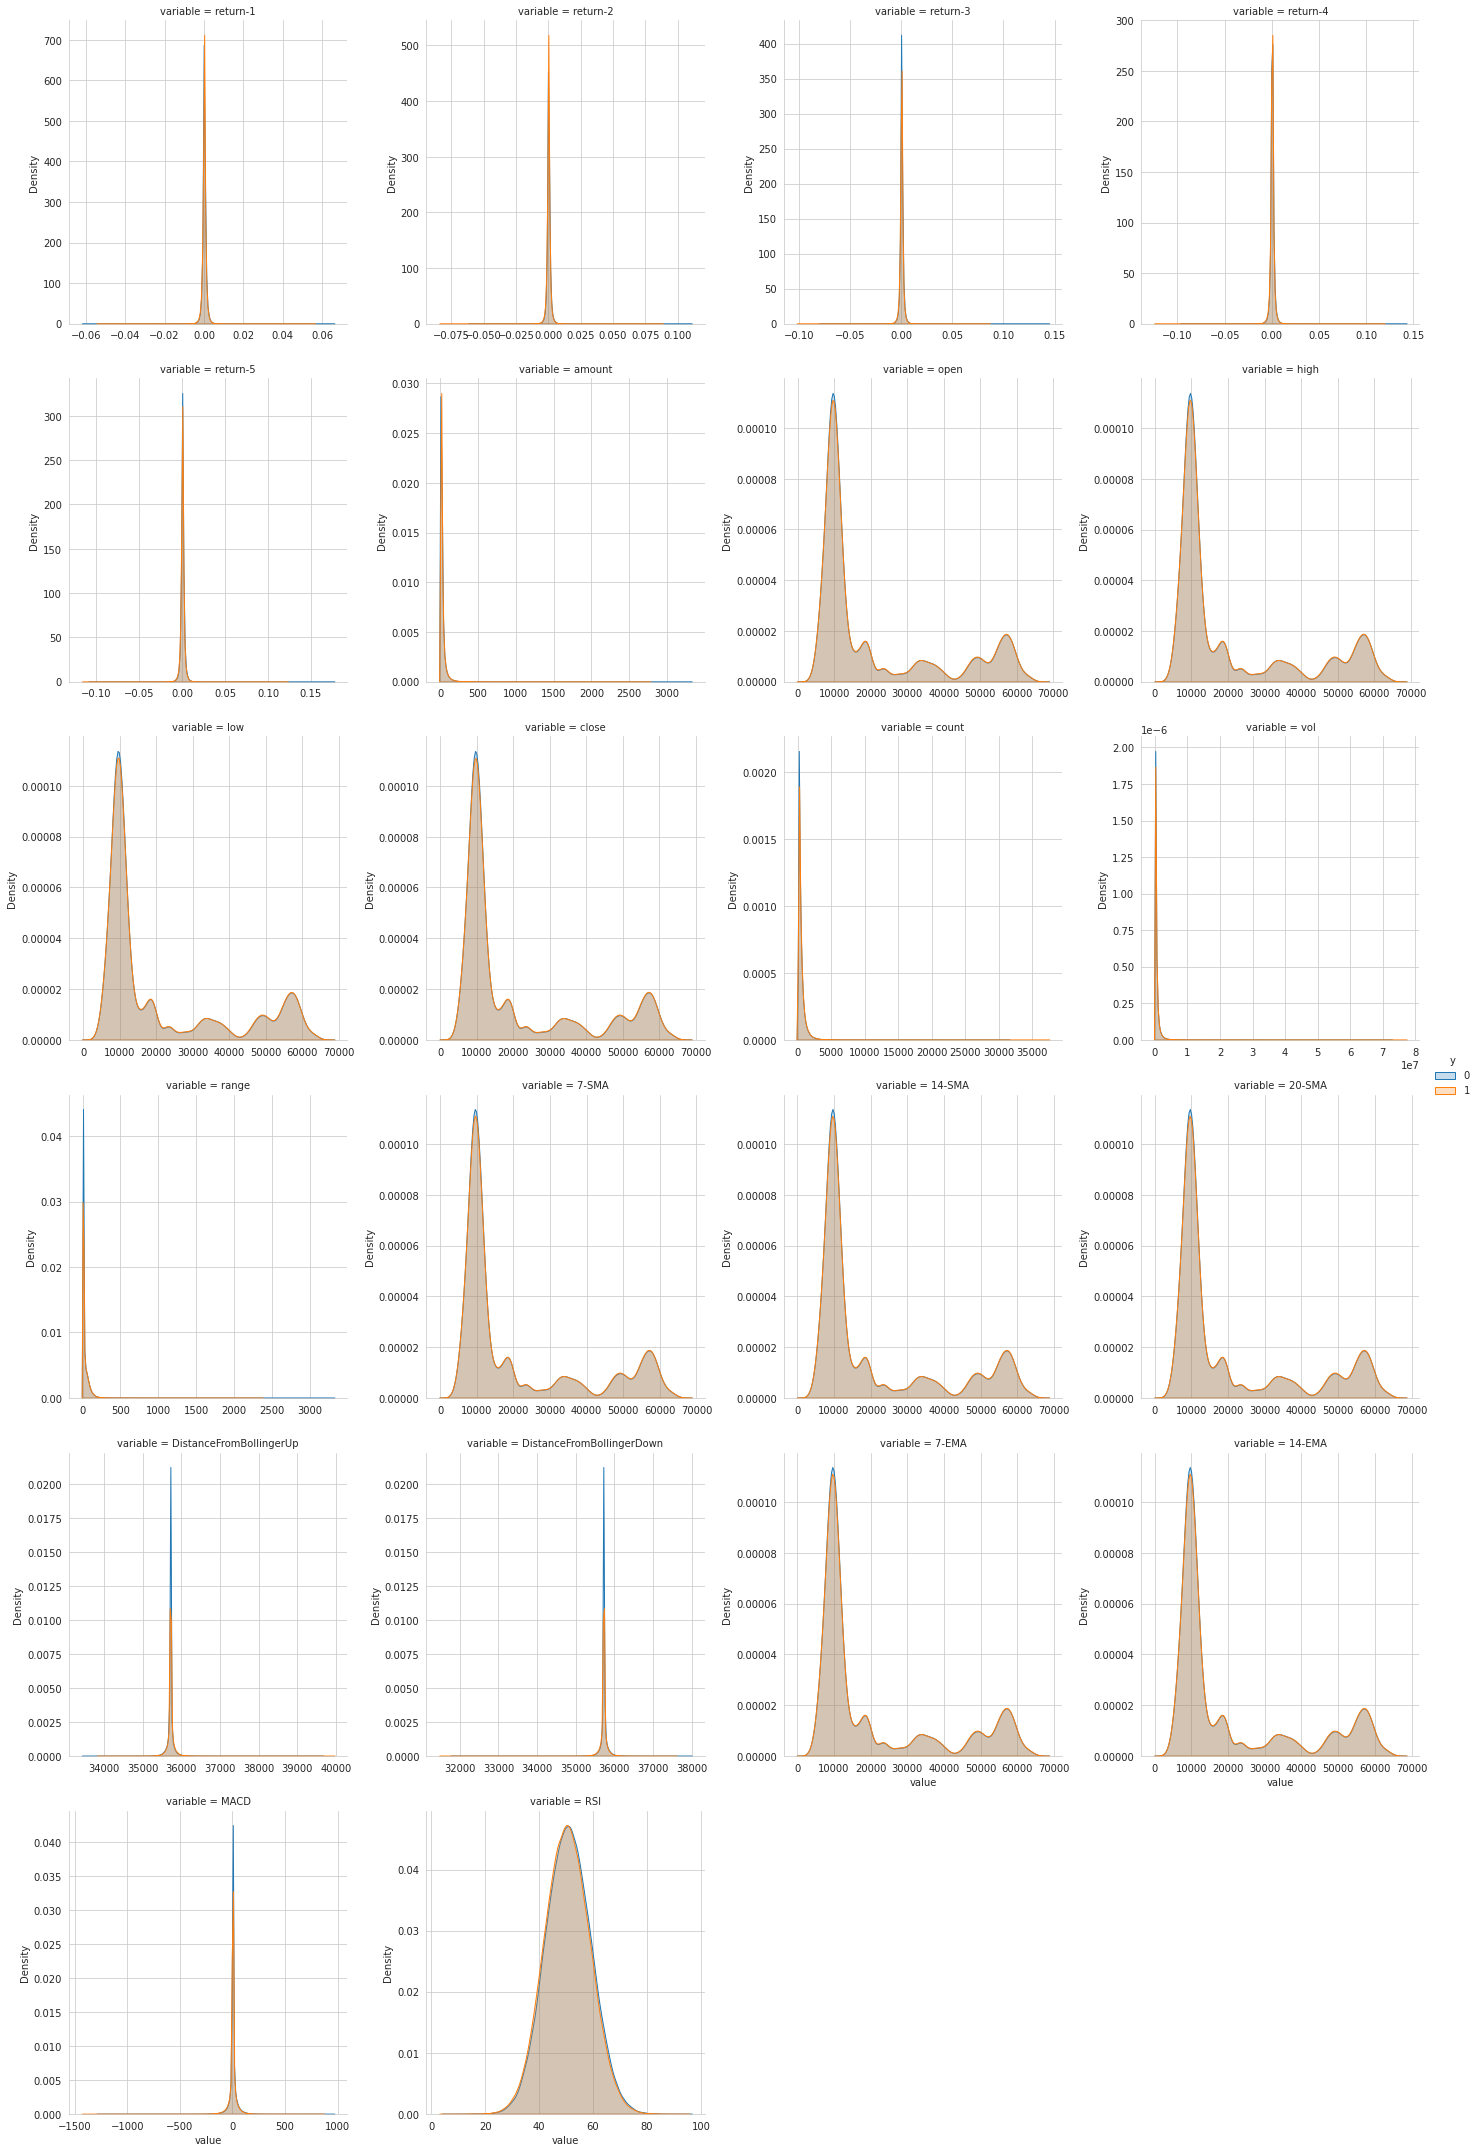

In [ ]:
plot_df = pd.concat([btc_X, btc_y], axis=1)
plot_df = pd.melt(plot_df, plot_df.columns[-1], plot_df.columns[:-1])
sns.set_style("whitegrid")
g = sns.FacetGrid(plot_df, col="variable", hue="y", col_wrap=4, sharex=False, sharey=False, height=5)
g.map(sns.kdeplot, "value", shade=True)
g.add_legend()
plt.show()

### Filter based/Model agnostic feature selection



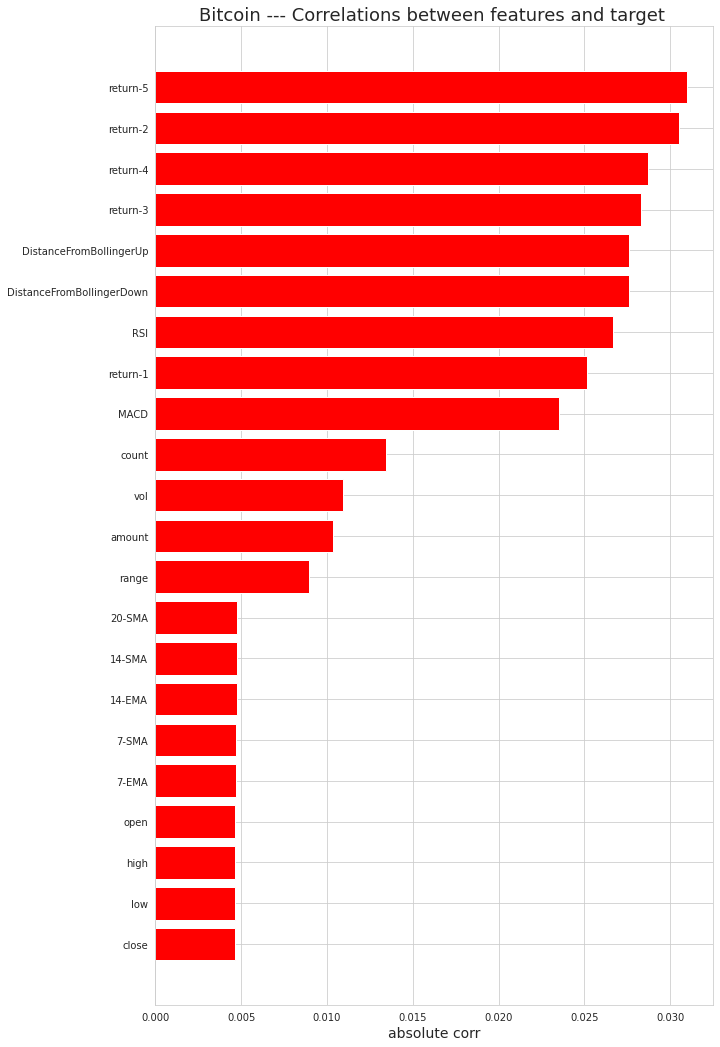

In [ ]:
#Standard Scaler ekle
ss = StandardScaler()
corr_df = pd.concat([btc_X, btc_y], axis=1)
corr_df = pd.DataFrame(ss.fit_transform(corr_df),columns = corr_df.columns)
corrmat = corr_df.corr(method='pearson', min_periods=1000)
# plot absolute values
corrmat = np.abs(corrmat)
corr_target = corrmat['y'].reset_index()[:-1]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Bitcoin --- Correlations between features and target ", fontsize = 18)
plt.show()

### Embedded/Model dependent feature selection

Tree-based: SelectFromModel




### Random Forest SelectFromModel

In [ ]:
ss = StandardScaler()
num_feats = len(btc_X.columns)
btc_X_scaled = pd.DataFrame(ss.fit_transform(btc_X),columns = btc_X.columns)

embedded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embedded_rf_selector.fit(btc_X_scaled.iloc[0:100000,:], np.asarray(btc_y.iloc[0:100000]).flatten())
embedded_rf_support = embedded_rf_selector.get_support()
embedded_rf_features = btc_X_scaled.loc[:,embedded_rf_support].columns.tolist()
print(str(len(embedded_rf_features)), 'selected features:')
print(embedded_rf_features)

13 selected features:
['return-1', 'return-2', 'return-3', 'return-4', 'return-5', 'amount', 'count', 'vol', 'range', 'DistanceFromBollingerUp', 'DistanceFromBollingerDown', 'MACD', 'RSI']


In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(btc_X_scaled.iloc[0:100000,:], np.asarray(btc_y.iloc[0:100000]).flatten())
coefficients = model.feature_importances_
absCoefficients = abs(coefficients)
columns = btc_X_scaled.columns
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('RandomForestClassifier - Feature Importance:')
print('\n',fullList,'\n')

RandomForestClassifier - Feature Importance:

                      Variable  absCoefficient
0                    return-1        0.060007
4                    return-5        0.058905
1                    return-2        0.058773
2                    return-3        0.058588
3                    return-4        0.058354
21                        RSI        0.058313
20                       MACD        0.057466
12                      range        0.056676
10                      count        0.053894
11                        vol        0.052199
17  DistanceFromBollingerDown        0.051825
5                      amount        0.051726
16    DistanceFromBollingerUp        0.051646
15                     20-SMA        0.031147
14                     14-SMA        0.030578
6                        open        0.030266
8                         low        0.030212
7                        high        0.030117
13                      7-SMA        0.030086
19                     14-EMA    

### Light Gradient Boosting Machine SelectFromModel

In [ ]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embedded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embedded_lgb_selector.fit(btc_X_scaled.iloc[0:100000,:], np.asarray(btc_y.iloc[0:100000]).flatten())

embedded_lgb_support = embedded_lgb_selector.get_support()
embedded_lgb_features = btc_X_scaled.loc[:,embedded_lgb_support].columns.tolist()
print(str(len(embedded_lgb_features)), 'selected features')
print(embedded_lgb_features)

12 selected features
['return-1', 'return-2', 'return-3', 'return-4', 'return-5', 'amount', 'count', 'vol', 'range', 'DistanceFromBollingerUp', 'MACD', 'RSI']


In [ ]:
model=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
model.fit(btc_X_scaled.iloc[0:100000,:], np.asarray(btc_y.iloc[0:100000]).flatten())
coefficients = model.feature_importances_
absCoefficients = abs(coefficients)
columns = btc_X_scaled.columns
fullList = pd.concat((pd.DataFrame(columns, columns = ['Variable']), pd.DataFrame(absCoefficients, columns = ['absCoefficient'])), axis = 1).sort_values(by='absCoefficient', ascending = False)
print('LGBMCClassifier - Feature Importance:')
print('\n',fullList,'\n')

LGBMCClassifier - Feature Importance:

                      Variable  absCoefficient
21                        RSI            1017
10                      count             923
12                      range             913
20                       MACD             833
4                    return-5             831
11                        vol             811
2                    return-3             803
3                    return-4             768
1                    return-2             751
16    DistanceFromBollingerUp             746
5                      amount             725
0                    return-1             708
17  DistanceFromBollingerDown             682
15                     20-SMA             655
9                       close             594
14                     14-SMA             570
19                     14-EMA             550
13                      7-SMA             548
18                      7-EMA             541
8                         low           

In [ ]:
selected_features = embedded_rf_features
print(str(len(embedded_rf_features)), 'selected features:')
print(selected_features)

13 selected features:
['return-1', 'return-2', 'return-3', 'return-4', 'return-5', 'amount', 'count', 'vol', 'range', 'DistanceFromBollingerUp', 'DistanceFromBollingerDown', 'MACD', 'RSI']


### Use blocking time series split for validation, split data set into training-validation-test

In [ ]:
def create_training_data(X, y, train_ratio=0.8, fold=10):
  train_window_size = int(len(X)*train_ratio/fold*train_ratio)
  valid_window_size = int(len(X)*train_ratio/fold*(1-train_ratio))
  test_window_size = int(len(X)*(1-train_ratio))

  test_X = X.tail(int(len(X)*(1-train_ratio)))
  test_y = y.tail(int(len(X)*(1-train_ratio)))
  
  train_valid_X = X.head(int(len(X)*(train_ratio)))
  train_valid_y = y.head(int(len(X)*(train_ratio)))

  return np.asarray(train_valid_X), np.asarray(train_valid_y).flatten(),  np.asarray(test_X), np.asarray(test_y).flatten()

In [ ]:
ada_train_valid_X, ada_train_valid_y, ada_test_X, ada_test_y = create_training_data(ada_X[selected_features], ada_y)
btc_train_valid_X, btc_train_valid_y, btc_test_X, btc_test_y = create_training_data(btc_X[selected_features], btc_y)
doge_train_valid_X, doge_train_valid_y, doge_test_X, doge_test_y = create_training_data(doge_X[selected_features], doge_y)
eth_train_valid_X, eth_train_valid_y, eth_test_X, eth_test_y = create_training_data(eth_X[selected_features], eth_y)
ltc_train_valid_X, ltc_train_valid_y, ltc_test_X, ltc_test_y = create_training_data(ltc_X[selected_features], ltc_y)


In [ ]:
print(np.shape(ada_test_X))
print(np.shape(ltc_test_y))
print(np.shape(doge_train_valid_X))
print(np.shape(eth_train_valid_y))
print(np.shape(btc_train_valid_X))
print(np.shape(btc_train_valid_y))

(144114, 13)
(144112,)
(576444, 13)
(576455,)
(576457, 13)
(576457,)


### Blocking Time Series split for Cross Validation

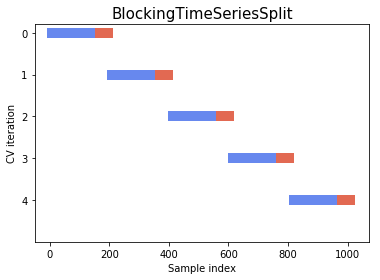




In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

## Model Selection: Hyperparameter Tuning via Cross Validation

1.   Baseline model: Decision Trees
2.   Logistic Regression
3.   Support Vector Machine
4.   Random Forest
5.   Multi-layer Perceptron
6.   Recurrent Neural Network (LSTM)



### Decision Tree (Baseline Model) Cross Validation HyperParameter Tuning 

In [ ]:
max_fs = ["sqrt", None , "log2"]
min_samples_leaf = [1,2,3,4,5]
max_depths = [10,30,50]
decision_score_list = []
print('max_features - min_samples_leaf - max_depth')
for maxf in max_fs:
  for mins in min_samples_leaf:
    for maxd in max_depths:
      model = make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_leaf=mins, max_depth = maxd, max_features = maxf))
      btscv = BlockingTimeSeriesSplit(n_splits=10)
      scores = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
      print(str(maxf) + ' - ' + str(mins) + ' - ' + str(maxd) + "  ---->  accuracy: {0:.5f}".format(scores.mean()))
      decision_score_list.append((maxf,mins,maxd,scores.mean()))

max_features - min_samples_leaf - max_depth
sqrt - 1 - 10  ---->  accuracy: 0.51535
sqrt - 1 - 30  ---->  accuracy: 0.50225
sqrt - 1 - 50  ---->  accuracy: 0.50585
sqrt - 2 - 10  ---->  accuracy: 0.51830
sqrt - 2 - 30  ---->  accuracy: 0.50025
sqrt - 2 - 50  ---->  accuracy: 0.50995
sqrt - 3 - 10  ---->  accuracy: 0.51400
sqrt - 3 - 30  ---->  accuracy: 0.50490
sqrt - 3 - 50  ---->  accuracy: 0.50815
sqrt - 4 - 10  ---->  accuracy: 0.51900
sqrt - 4 - 30  ---->  accuracy: 0.51005
sqrt - 4 - 50  ---->  accuracy: 0.50915
sqrt - 5 - 10  ---->  accuracy: 0.51040
sqrt - 5 - 30  ---->  accuracy: 0.50550
sqrt - 5 - 50  ---->  accuracy: 0.51110
None - 1 - 10  ---->  accuracy: 0.51645
None - 1 - 30  ---->  accuracy: 0.51095
None - 1 - 50  ---->  accuracy: 0.50880
None - 2 - 10  ---->  accuracy: 0.51655
None - 2 - 30  ---->  accuracy: 0.51160
None - 2 - 50  ---->  accuracy: 0.51065
None - 3 - 10  ---->  accuracy: 0.51535
None - 3 - 30  ---->  accuracy: 0.51145
None - 3 - 50  ---->  accuracy: 0.51

In [ ]:
best_arg_decision_tree = max(decision_score_list, key=lambda x:x[3])
best_arg_decision_tree

('sqrt', 4, 10, 0.5189999999999999)

### Logistic Regression Cross Validation HyperParameter Tuning

In [ ]:
logistic_score_list=[]
penalties = ["l1","l2", "none"]
for pen in penalties:
  model = make_pipeline(StandardScaler(), LogisticRegression(penalty=pen, solver="saga", max_iter=1000, n_jobs=-1))
  btscv = BlockingTimeSeriesSplit(n_splits=10)
  scores = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
  print(pen + " accuracy: {0:.5f} ".format(scores.mean()))
  logistic_score_list.append(scores.mean())

l1 accuracy: 0.52755 
l2 accuracy: 0.52735 
none accuracy: 0.52690 


In [ ]:
best_arg_logistic_regression = penalties[logistic_score_list.index(max(logistic_score_list))]
print(best_arg_logistic_regression + ', '+ str(max(logistic_score_list)))

l1, 0.52755


### Support Vector Classifier Cross Validation HyperParameter Tuning

In [ ]:
regularizations = [0.01, 0.1, 1, 10, 100]
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
SVC_score_list = []

print('regularizations (C) - kernels')
for r in regularizations:
  for k in kernels:
    model = make_pipeline(StandardScaler(), SVC(C = r, kernel= k))
    btscv = BlockingTimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
    print(str(r) + ' - ' + k  + "  ----> accuracy: {0:.5f}".format(scores.mean()))
    SVC_score_list.append((r,k,scores.mean()))

regularizations (C) - kernels
0.01 - rbf  ----> accuracy: 0.51310
0.01 - linear  ----> accuracy: 0.51855
0.01 - poly  ----> accuracy: 0.50940
0.01 - sigmoid  ----> accuracy: 0.51565
0.1 - rbf  ----> accuracy: 0.52940
0.1 - linear  ----> accuracy: 0.51995
0.1 - poly  ----> accuracy: 0.51085
0.1 - sigmoid  ----> accuracy: 0.51145
1 - rbf  ----> accuracy: 0.53010
1 - linear  ----> accuracy: 0.51935
1 - poly  ----> accuracy: 0.51160
1 - sigmoid  ----> accuracy: 0.51085
10 - rbf  ----> accuracy: 0.52175
10 - linear  ----> accuracy: 0.51975
10 - poly  ----> accuracy: 0.51270
10 - sigmoid  ----> accuracy: 0.51085
100 - rbf  ----> accuracy: 0.51550
100 - linear  ----> accuracy: 0.51925
100 - poly  ----> accuracy: 0.51475
100 - sigmoid  ----> accuracy: 0.51100


In [ ]:
best_arg_svc = max(SVC_score_list, key=lambda x:x[2])
best_arg_svc

(1, 'rbf', 0.5300999999999999)

### Random Forest Cross Validation HyperParameter Tuning

In [ ]:
num_estimators = [50,100,200]
max_fs_rf = [None, "sqrt", "log2"]
min_samples_leaf_rf = [1,3,5]
max_depths_rf = [2,5,8]
random_forest_score_list = []
print('num_estimators - max_features - min_samples_leaf - max_depth')
for est in  num_estimators:
  for maxf in max_fs_rf:
    for mins in min_samples_leaf_rf:
      for maxd in max_depths_rf:
        model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = est, min_samples_leaf=mins, max_depth = maxd, max_features = maxf))
        btscv = BlockingTimeSeriesSplit(n_splits=10)
        scores = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
        print(str(est) + ' - ' + str(maxf) + ' - ' + str(mins) + ' - ' + str(maxd) + "  ----> accuracy: {0:.5f} ".format(scores.mean()))
        random_forest_score_list.append((est, maxf, mins, maxd,scores.mean()))

num_estimators - max_features - min_samples_leaf - max_depth
50 - None - 1 - 2  ----> accuracy: 0.52885 
50 - None - 1 - 5  ----> accuracy: 0.52695 
50 - None - 1 - 8  ----> accuracy: 0.52185 
50 - None - 3 - 2  ----> accuracy: 0.52900 
50 - None - 3 - 5  ----> accuracy: 0.52705 
50 - None - 3 - 8  ----> accuracy: 0.52130 
50 - None - 5 - 2  ----> accuracy: 0.52550 
50 - None - 5 - 5  ----> accuracy: 0.53005 
50 - None - 5 - 8  ----> accuracy: 0.52280 
50 - sqrt - 1 - 2  ----> accuracy: 0.52895 
50 - sqrt - 1 - 5  ----> accuracy: 0.52955 
50 - sqrt - 1 - 8  ----> accuracy: 0.52145 
50 - sqrt - 3 - 2  ----> accuracy: 0.52905 
50 - sqrt - 3 - 5  ----> accuracy: 0.52975 
50 - sqrt - 3 - 8  ----> accuracy: 0.52405 
50 - sqrt - 5 - 2  ----> accuracy: 0.52900 
50 - sqrt - 5 - 5  ----> accuracy: 0.52740 
50 - sqrt - 5 - 8  ----> accuracy: 0.52505 
50 - log2 - 1 - 2  ----> accuracy: 0.52710 
50 - log2 - 1 - 5  ----> accuracy: 0.52795 
50 - log2 - 1 - 8  ----> accuracy: 0.52560 
50 - log2 - 3 -

In [ ]:
best_arg_rf = max(random_forest_score_list, key=lambda x:x[4])
best_arg_rf

(200, 'log2', 5, 5, 0.53185)

### Multi-Layer Perceptron Cross Validation HyperParameter Tuning

In [ ]:
hidden_layers = [(40,2),(100,40,2),(150,75,30,2)]
learning_rates = ['invscaling','adaptive']
learning_rate_inits = [0.0001, 0.001, 0.01, 0.1]
epsilon = [10 ** -6, 10 ** -8, 10 ** -10]
mlp_list = []

print('hidden_layer_sizes - learning_rate - learning_rate_init - epsilon')
for h in hidden_layers:
  for lr in learning_rates:
    for lr_in in learning_rate_inits:
      for e in epsilon:
        model = make_pipeline(StandardScaler(), MLPClassifier(epsilon = e, hidden_layer_sizes = h, learning_rate= lr, learning_rate_init = lr_in, shuffle = False, warm_start = True, max_iter = 800, early_stopping = True))
        btscv = BlockingTimeSeriesSplit(n_splits=10)
        scores = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
        print(str(h) + ' - ' + lr + ' - ' + str(lr_in) +  ' - ' +str(e) + "  ----> accuracy: {0:.5f} ".format(scores.mean()))
        mlp_list.append((h, lr, lr_in, e, scores.mean()))


hidden_layer_sizes - learning_rate - learning_rate_init - epsilon
(40, 2) - invscaling - 0.0001 - 1e-06  ----> accuracy: 0.50835 
(40, 2) - invscaling - 0.0001 - 1e-08  ----> accuracy: 0.51460 
(40, 2) - invscaling - 0.0001 - 1e-10  ----> accuracy: 0.49760 
(40, 2) - invscaling - 0.001 - 1e-06  ----> accuracy: 0.50980 
(40, 2) - invscaling - 0.001 - 1e-08  ----> accuracy: 0.52300 
(40, 2) - invscaling - 0.001 - 1e-10  ----> accuracy: 0.52075 
(40, 2) - invscaling - 0.01 - 1e-06  ----> accuracy: 0.51765 
(40, 2) - invscaling - 0.01 - 1e-08  ----> accuracy: 0.52100 
(40, 2) - invscaling - 0.01 - 1e-10  ----> accuracy: 0.52560 
(40, 2) - invscaling - 0.1 - 1e-06  ----> accuracy: 0.50125 
(40, 2) - invscaling - 0.1 - 1e-08  ----> accuracy: 0.50960 
(40, 2) - invscaling - 0.1 - 1e-10  ----> accuracy: 0.50755 
(40, 2) - adaptive - 0.0001 - 1e-06  ----> accuracy: 0.51725 
(40, 2) - adaptive - 0.0001 - 1e-08  ----> accuracy: 0.50055 
(40, 2) - adaptive - 0.0001 - 1e-10  ----> accuracy: 0.50845

In [ ]:
best_arg_mlp= max(mlp_list, key=lambda x:x[4])
best_arg_mlp

((150, 75, 30, 2), 'adaptive', 0.001, 1e-08, 0.5323499999999999)

### RNN Cross Validation HyperParameter Tuning

In [ ]:
def build_rnn_gru():
    model= Sequential([
        Embedding(input_dim=13, output_dim=128),
        GRU(64, activation = "tanh", return_sequences=True),
        GRU(32, activation = "tanh", return_sequences=True),
        GRU(16, activation = "tanh"),
        Dense(8),
	      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return(model)

def build_rnn_lstm():
    model= Sequential([
        Embedding(input_dim=13, output_dim=128),
        LSTM(64, activation='tanh', recurrent_activation = "sigmoid", return_sequences=True),
        LSTM(32, activation='tanh', return_sequences=True),
        LSTM(16, activation='tanh'),
        Dense(8),
	      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return(model)

In [ ]:
funs = [build_rnn_gru, build_rnn_lstm]
fun_name = ['GRU','LSTM']
rnn_list = []
print('build_fn')
for i in range(2):
  model = make_pipeline(StandardScaler(), KerasClassifier(build_fn=funs[i], verbose=0))
  btscv = BlockingTimeSeriesSplit(n_splits=10)
  results = cross_val_score(model, btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)], cv=btscv, scoring="accuracy")
  print(fun_name[i] + "  ----> accuracy: {0:.5f} ".format(results.mean()))
  rnn_list.append((fun_name[i], results.mean()))

build_fn


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


GRU  ----> accuracy: 0.51355 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


LSTM  ----> accuracy: 0.50725 


In [ ]:
best_arg_rnn = max(rnn_list, key=lambda x:x[1])
best_arg_rnn

('GRU', 0.5135500000000001)

## Model training

**Train models using optimal hyperparameters**

In [ ]:
def vary_end_time(model, test_X, test_y):
  end_time_test = [15, 100, 1000, 10000]
  accuracy_list = []
  for e in end_time_test:
    acc = model.score(test_X[0:e,:], test_y[0:e])
    accuracy_list.append(acc)
    print('First '+ str(e) + ' minutes - ' + "  ----> accuracy: {0:.5f} ".format(acc))
  return accuracy_list

In [ ]:
train_X_list = [ada_train_valid_X, btc_train_valid_X, doge_train_valid_X, eth_train_valid_X, ltc_train_valid_X]
train_y_list = [ada_train_valid_y, btc_train_valid_y, doge_train_valid_y, eth_train_valid_y, ltc_train_valid_y]
test_X_list = [ada_test_X, btc_test_X, doge_test_X, eth_test_X, ltc_test_X]
test_y_list = [ada_test_y, btc_test_y, doge_test_y, eth_test_y, ltc_test_y]

coin_names = ['ADA', 'BTC', 'DOGE', 'ETH', 'LTC']

# Decision Tree

In [ ]:
#('sqrt', 4, 10, 0.5189999999999999)
acc_list_coins_dt = []
for i in range(5):
  print('------- ' + coin_names[i] + ' -------')
  dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_leaf=4, max_depth = 10, max_features = 'sqrt'))
  dt.fit(train_X_list[i], train_y_list[i])
  model_name = 'decision_tree_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(dt, file)
  acc_list_coins_dt.append(vary_end_time(dt, test_X_list[i], test_y_list[i]))
  del dt
  gc.collect()

------- ADA -------
First 15 minutes -   ----> accuracy: 0.40000 
First 100 minutes -   ----> accuracy: 0.51000 
First 1000 minutes -   ----> accuracy: 0.53500 
First 10000 minutes -   ----> accuracy: 0.50490 
------- BTC -------
First 15 minutes -   ----> accuracy: 0.66667 
First 100 minutes -   ----> accuracy: 0.62000 
First 1000 minutes -   ----> accuracy: 0.53100 
First 10000 minutes -   ----> accuracy: 0.51670 
------- DOGE -------
First 15 minutes -   ----> accuracy: 0.40000 
First 100 minutes -   ----> accuracy: 0.48000 
First 1000 minutes -   ----> accuracy: 0.50600 
First 10000 minutes -   ----> accuracy: 0.51220 
------- ETH -------
First 15 minutes -   ----> accuracy: 0.80000 
First 100 minutes -   ----> accuracy: 0.53000 
First 1000 minutes -   ----> accuracy: 0.49900 
First 10000 minutes -   ----> accuracy: 0.50160 
------- LTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.54000 
First 1000 minutes -   ----> accuracy: 0.52800

### Multi Layer Perceptron

In [ ]:
acc_list_coins_mlp = []
for i in range(5):
  print('------- ' + coin_names[i] + ' -------')
  mlp = make_pipeline(StandardScaler(), MLPClassifier(epsilon = 1e-08, hidden_layer_sizes = (150, 75, 30, 2), learning_rate= 'adaptive', learning_rate_init = 0.001,
                                                    shuffle = False, warm_start = True, max_iter = 800, early_stopping = True, verbose = False))
  mlp.fit(train_X_list[i], train_y_list[i])
  model_name = 'mlp_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(mlp, file)
  acc_list_coins_mlp.append(vary_end_time(mlp, test_X_list[i], test_y_list[i]))
  del mlp
  gc.collect()

------- ADA -------
First 15 minutes -   ----> accuracy: 0.66667 
First 100 minutes -   ----> accuracy: 0.61000 
First 1000 minutes -   ----> accuracy: 0.52400 
First 10000 minutes -   ----> accuracy: 0.51300 
------- BTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.58000 
First 1000 minutes -   ----> accuracy: 0.53300 
First 10000 minutes -   ----> accuracy: 0.52190 
------- DOGE -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.55000 
First 1000 minutes -   ----> accuracy: 0.49000 
First 10000 minutes -   ----> accuracy: 0.51530 
------- ETH -------
First 15 minutes -   ----> accuracy: 0.40000 
First 100 minutes -   ----> accuracy: 0.53000 
First 1000 minutes -   ----> accuracy: 0.49700 
First 10000 minutes -   ----> accuracy: 0.51660 
------- LTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.57000 
First 1000 minutes -   ----> accuracy: 0.51900

### Logistic Regression

In [ ]:
acc_list_coins_logistic = []
for i in range(5):
  print('------- ' + coin_names[i] + ' -------')
  logistic = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver="saga", max_iter=1000, n_jobs=-1))
  logistic.fit(train_X_list[i], train_y_list[i])
  model_name = 'logistic_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(logistic, file)
  acc_list_coins_logistic.append(vary_end_time(logistic, test_X_list[i], test_y_list[i]))

  del logistic
  gc.collect()

------- ADA -------
First 15 minutes -   ----> accuracy: 0.80000 
First 100 minutes -   ----> accuracy: 0.57000 
First 1000 minutes -   ----> accuracy: 0.51900 
First 10000 minutes -   ----> accuracy: 0.50620 
------- BTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.57000 
First 1000 minutes -   ----> accuracy: 0.55000 
First 10000 minutes -   ----> accuracy: 0.52340 
------- DOGE -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.52000 
First 1000 minutes -   ----> accuracy: 0.47600 
First 10000 minutes -   ----> accuracy: 0.50450 
------- ETH -------
First 15 minutes -   ----> accuracy: 0.66667 
First 100 minutes -   ----> accuracy: 0.56000 
First 1000 minutes -   ----> accuracy: 0.50300 
First 10000 minutes -   ----> accuracy: 0.50800 
------- LTC -------
First 15 minutes -   ----> accuracy: 0.46667 
First 100 minutes -   ----> accuracy: 0.50000 
First 1000 minutes -   ----> accuracy: 0.52700

### Random Forest Classifier

In [ ]:
#(200, 'log2', 5, 5, 0.53185)
acc_list_coins_rf = []
for i in range(5):
  print('------- ' + coin_names[i] + ' -------')
  rf= make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 200, min_samples_leaf=5, max_depth = 5, max_features = 'log2'))
  rf.fit(train_X_list[i], train_y_list[i])
  model_name = 'rf_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(rf, file)
  acc_list_coins_rf.append(vary_end_time(rf, test_X_list[i], test_y_list[i]))
  del rf
  gc.collect()

------- ADA -------
First 15 minutes -   ----> accuracy: 0.33333 
First 100 minutes -   ----> accuracy: 0.53000 
First 1000 minutes -   ----> accuracy: 0.52900 
First 10000 minutes -   ----> accuracy: 0.51290 
------- BTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.54000 
First 1000 minutes -   ----> accuracy: 0.53400 
First 10000 minutes -   ----> accuracy: 0.52650 
------- DOGE -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.53000 
First 1000 minutes -   ----> accuracy: 0.50600 
First 10000 minutes -   ----> accuracy: 0.51930 
------- ETH -------
First 15 minutes -   ----> accuracy: 0.73333 
First 100 minutes -   ----> accuracy: 0.58000 
First 1000 minutes -   ----> accuracy: 0.50400 
First 10000 minutes -   ----> accuracy: 0.51180 
------- LTC -------
First 15 minutes -   ----> accuracy: 0.60000 
First 100 minutes -   ----> accuracy: 0.54000 
First 1000 minutes -   ----> accuracy: 0.51600

# Recurrent Neural Network

In [ ]:
acc_list_coins_rnn = []
for i in range(5):
  print('------- ' + coin_names[i] + ' -------')
  rnn = make_pipeline(StandardScaler(), KerasClassifier(build_fn= build_rnn_gru, verbose=0))
  rnn.fit(train_X_list[i], train_y_list[i])
  model_name = 'rnn_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(rnn, file)
  acc_list_coins_rnn.append(vary_end_time(rnn, test_X_list[i], test_y_list[i]))
  del rnn
  gc.collect()

------- ADA -------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


INFO:tensorflow:Assets written to: ram://1ee61b0d-ae0c-4ff5-9dee-5689ed2faa66/assets


INFO:tensorflow:Assets written to: ram://1ee61b0d-ae0c-4ff5-9dee-5689ed2faa66/assets


First 15 minutes -   ----> accuracy: 0.60000 
First 100 minutes -   ----> accuracy: 0.55000 
First 1000 minutes -   ----> accuracy: 0.52400 
First 10000 minutes -   ----> accuracy: 0.49130 
------- BTC -------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


INFO:tensorflow:Assets written to: ram://c4eae4b0-af35-4237-97fc-a9af6e788ffb/assets


INFO:tensorflow:Assets written to: ram://c4eae4b0-af35-4237-97fc-a9af6e788ffb/assets


First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.51000 
First 1000 minutes -   ----> accuracy: 0.52900 
First 10000 minutes -   ----> accuracy: 0.52880 
------- DOGE -------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


INFO:tensorflow:Assets written to: ram://f1596a3b-d2e0-4885-8839-6cdd8da3b0f4/assets


INFO:tensorflow:Assets written to: ram://f1596a3b-d2e0-4885-8839-6cdd8da3b0f4/assets


First 15 minutes -   ----> accuracy: 0.33333 
First 100 minutes -   ----> accuracy: 0.51000 
First 1000 minutes -   ----> accuracy: 0.48100 
First 10000 minutes -   ----> accuracy: 0.51400 
------- ETH -------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


INFO:tensorflow:Assets written to: ram://2ca02fdd-b905-44e3-8476-c7ef06e3a34d/assets


INFO:tensorflow:Assets written to: ram://2ca02fdd-b905-44e3-8476-c7ef06e3a34d/assets


First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.55000 
First 1000 minutes -   ----> accuracy: 0.49800 
First 10000 minutes -   ----> accuracy: 0.51230 
------- LTC -------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


INFO:tensorflow:Assets written to: ram://2a625974-e7a6-4b59-9a4a-382656d21ff5/assets


INFO:tensorflow:Assets written to: ram://2a625974-e7a6-4b59-9a4a-382656d21ff5/assets


First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.54000 
First 1000 minutes -   ----> accuracy: 0.51300 
First 10000 minutes -   ----> accuracy: 0.50380 


### Support Vector Classifier

In [ ]:
#ADA - BTC - DOGE
acc_list_coins_svc = []
for i in range(5):
  #btc_train_valid_X[len(btc_train_valid_y)-100000:len(btc_train_valid_y),:], btc_train_valid_y[len(btc_train_valid_y)-100000:len(btc_train_valid_y)]
  print('------- ' + coin_names[i] + ' -------')
  svc = make_pipeline(StandardScaler(), SVC(C = 1, kernel = 'rbf', probability = False))
  svc.fit((train_X_list[i])[len(train_y_list[i])-200000:len(train_y_list[i]),:], (train_y_list[i])[len(train_y_list[i])-200000:len(train_y_list[i])])
  print('------- ' + coin_names[i] + ' -------')
  model_name = 'svc_' + coin_names[i]
  filename = model_name + '.pkl'
  with open(filename, 'wb') as file:
    pickle.dump(svc, file)
  acc_list_coins_svc.append(vary_end_time(svc, test_X_list[i], test_y_list[i]))
  del svc
  gc.collect()

------- ADA -------
------- ADA -------
First 15 minutes -   ----> accuracy: 0.46667 
First 100 minutes -   ----> accuracy: 0.64000 
First 1000 minutes -   ----> accuracy: 0.53100 
First 10000 minutes -   ----> accuracy: 0.50850 
------- BTC -------
------- BTC -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.61000 
First 1000 minutes -   ----> accuracy: 0.54800 
First 10000 minutes -   ----> accuracy: 0.52900 
------- DOGE -------
------- DOGE -------
First 15 minutes -   ----> accuracy: 0.53333 
First 100 minutes -   ----> accuracy: 0.51000 
First 1000 minutes -   ----> accuracy: 0.50100 
First 10000 minutes -   ----> accuracy: 0.51550 
------- ETH -------


In [ ]:
#ETH
print('------- ' + coin_names[3] + ' -------')
with open('svc_ETH.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

vary_end_time(pickle_model, test_X_list[3], test_y_list[3])


------- ETH -------
First 15 minutes -   ----> accuracy: 0.46667 
First 100 minutes -   ----> accuracy: 0.50000 
First 1000 minutes -   ----> accuracy: 0.50600 
First 10000 minutes -   ----> accuracy: 0.51630 


[0.4666666666666667, 0.5, 0.506, 0.5163]

In [ ]:
#LTC
print('------- ' + coin_names[4] + ' -------')
with open('svc_LTC.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

vary_end_time(pickle_model, test_X_list[4], test_y_list[4])

------- LTC -------
First 15 minutes -   ----> accuracy: 0.40000 
First 100 minutes -   ----> accuracy: 0.52000 
First 1000 minutes -   ----> accuracy: 0.51700 
First 10000 minutes -   ----> accuracy: 0.51050 


[0.4, 0.52, 0.517, 0.5105]